In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os 
import json

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from data import ImageCaptionDataset, generate_batch
from model import ImageCaptionModel
from torch.utils.data import DataLoader
import torch


In [3]:
data_path = 'data'
imgs_path = "data/img"

In [4]:
captions_json = {f.replace('captions_','').replace('2014.json',''):f for f in os.listdir(data_path) if f.startswith('caption')}
captions_json

{'val': 'captions_val2014.json', 'train': 'captions_train2014.json'}

In [5]:
df_train, df_val = load_images(captions_json, imgs_path)

In [6]:
#plot_images(df_train, os.path.join(imgs_path,'train'))
#plot_images(df_val, os.path.join(imgs_path,'val'))

In [7]:
transform = get_transform()
transform

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    RandomCrop(size=(224, 224), padding=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
)

In [8]:
dataset = ImageCaptionDataset(transform=transform, 
                              df=df_train, 
                              img_path= os.path.join(imgs_path, 'train')
                              )

In [9]:
dataset.char_to_id('<pad>')

1

In [10]:
BATCH_SIZE = 4

In [11]:
train_loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, collate_fn=generate_batch)

In [12]:
vocab_size = len(train_loader.dataset.vocab)
vocab_size

7967

# Model

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*4cE8ZvhN7c_xQRgi.png)

In [13]:
import torch
import torch.nn as nn
from torchvision import transforms

In [14]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform_train = get_transform(mean=mean, std=std)

# Specify the batch size.
batch_size = 10

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
SIDE_SIZE = 224
MEAN = [0.45, 0.45, 0.45]
STD = [0.225, 0.225, 0.225]
CROP_SIZE = 224

In [17]:
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [18]:
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          

In [31]:
model = ImageCaptionModel(embed_size, hidden_size, vocab_size)

In [32]:
model = model.to(device)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [34]:
import numpy as np
from tqdm.auto import tqdm

In [35]:
loss_total = []
for epoch in tqdm(range(1, 5+1)):
    loss_epoch = []
    for images, captions in tqdm(train_loader):
        
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        optimizer.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        outputs = model(images, captions)
        #print(outputs.shape)
        #print(captions.shape)
        #print(captions.contiguous().view(-1).shape)
        #print(outputs.contiguous().view(-1, vocab_size).shape)
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.contiguous().view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
        
        loss_epoch.append(loss.item())
            
        # Get training statistics.
    loss_total.append(np.mean(loss_epoch))
    stats = 'Epoch [%d], Loss: %.4f,' % (epoch, loss_total[-1])
    print(stats)
        

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8073 [00:00<?, ?it/s]

Epoch [1], Loss: 2.5724,


  0%|          | 0/8073 [00:00<?, ?it/s]

Epoch [2], Loss: 2.0629,


  0%|          | 0/8073 [00:00<?, ?it/s]

Epoch [3], Loss: 1.8492,


  0%|          | 0/8073 [00:00<?, ?it/s]

Epoch [4], Loss: 1.6732,


  0%|          | 0/8073 [00:00<?, ?it/s]

Epoch [5], Loss: 1.5254,


In [36]:
import matplotlib.pyplot as plt

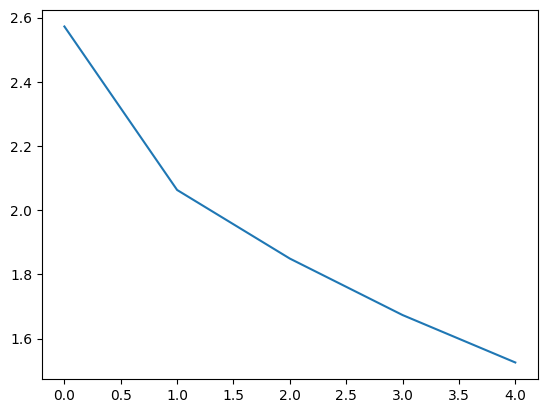

In [37]:
plt.plot(loss_total)